# **Introduction to Computer Vision**

Term Project : ResNet-50 from Scratch Trained on the POC Dataset

202111941 PARK SEJIN

In [7]:
# ============================================
# Colab + GPU (CuPy)
# ============================================

from google.colab import drive
drive.mount('/content/drive')

import subprocess
import sys

print("Setting up GPU environment...")
try:
    import cupy as cp
    print("CuPy already installed")
except ImportError:
    print("Installing CuPy...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "cupy-cuda12x", "-q"])
    import cupy as cp
    print("CuPy installed!")

import numpy as np
import os
from PIL import Image
import pickle
import json
import matplotlib.pyplot as plt

# GPU
USE_GPU = True
if USE_GPU:
    try:
        xp = cp
        print(f"Using GPU: {cp.cuda.Device()}")
        print(f"GPU Memory: {cp.cuda.Device().mem_info[1] / 1e9:.1f} GB\n")
    except:
        xp = np
        USE_GPU = False
        print("GPU not available, falling back to CPU\n")
else:
    xp = np
    print("Using CPU (NumPy)\n")

BASE_PATH = '/content/drive/MyDrive/POC_Dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setting up GPU environment...
CuPy already installed
Using GPU: <CUDA Device 0>
GPU Memory: 15.8 GB



In [8]:
# ============================================
# Utility Func
# ============================================

def to_cpu(x):
    if USE_GPU:
        return cp.asnumpy(x)
    return x

def to_gpu(x):
    if USE_GPU:
        return cp.asarray(x)
    return x

def im2col(x, fh, fw, stride, pad):
    n, c, h, w = x.shape
    oh = (h + 2*pad - fh) // stride + 1
    ow = (w + 2*pad - fw) // stride + 1

    x_pad = xp.pad(x, [(0,0), (0,0), (pad,pad), (pad,pad)], 'constant')
    col = xp.zeros((n, c, fh, fw, oh, ow), dtype=x.dtype)

    for y in range(fh):
        y_max = y + stride*oh
        for x_pos in range(fw):
            x_max = x_pos + stride*ow
            col[:, :, y, x_pos, :, :] = x_pad[:, :, y:y_max:stride, x_pos:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(n*oh*ow, -1)
    return col

def col2im(col, x_shape, fh, fw, stride, pad):
    n, c, h, w = x_shape
    oh = (h + 2*pad - fh) // stride + 1
    ow = (w + 2*pad - fw) // stride + 1

    col = col.reshape(n, oh, ow, c, fh, fw).transpose(0, 3, 4, 5, 1, 2)

    x = xp.zeros((n, c, h + 2*pad + stride - 1, w + 2*pad + stride - 1), dtype=col.dtype)
    for y in range(fh):
        y_max = y + stride*oh
        for x_pos in range(fw):
            x_max = x_pos + stride*ow
            x[:, :, y:y_max:stride, x_pos:x_max:stride] += col[:, :, y, x_pos, :, :]

    return x[:, :, pad:h+pad, pad:w+pad]

In [9]:
# ============================================
# Layer class
# ============================================

class Conv2D:
    def __init__(self, in_ch, out_ch, ksize, stride=1, pad=0):
        self.W = xp.random.randn(out_ch, in_ch, ksize, ksize).astype(xp.float32) * xp.sqrt(2.0 / (in_ch * ksize * ksize))
        self.b = xp.zeros(out_ch, dtype=xp.float32)
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        fh, fw = self.W.shape[2:]
        n, c, h, w = x.shape
        oh = (h + 2*self.pad - fh) // self.stride + 1
        ow = (w + 2*self.pad - fw) // self.stride + 1

        col = im2col(x, fh, fw, self.stride, self.pad)
        col_W = self.W.reshape(self.W.shape[0], -1).T

        out = xp.dot(col, col_W) + self.b
        out = out.reshape(n, oh, ow, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W
        return out

    def backward(self, dout):
        fh, fw = self.W.shape[2:]
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, self.W.shape[0])

        self.db = xp.sum(dout, axis=0)
        self.dW = xp.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(self.W.shape)

        dcol = xp.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, fh, fw, self.stride, self.pad)
        return dx

class BatchNorm:
    def __init__(self, num_features, momentum=0.9):
        self.gamma = xp.ones(num_features, dtype=xp.float32)
        self.beta = xp.zeros(num_features, dtype=xp.float32)
        self.momentum = momentum
        self.running_mean = xp.zeros(num_features, dtype=xp.float32)
        self.running_var = xp.ones(num_features, dtype=xp.float32)

    def forward(self, x, train=True):
        if x.ndim == 4:
            n, c, h, w = x.shape
            x = x.transpose(0, 2, 3, 1).reshape(-1, c)

        if train:
            mean = x.mean(axis=0)
            var = x.var(axis=0)
            std = xp.sqrt(var + 1e-5)
            xc = x - mean
            xn = xc / std

            self.batch_mean = mean
            self.xc = xc
            self.xn = xn
            self.std = std

            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        else:
            xc = x - self.running_mean
            xn = xc / xp.sqrt(self.running_var + 1e-5)

        out = self.gamma * xn + self.beta
        out = out.reshape(n, h, w, c).transpose(0, 3, 1, 2)
        return out

    def backward(self, dout):
        if dout.ndim == 4:
            n, c, h, w = dout.shape
            dout = dout.transpose(0, 2, 3, 1).reshape(-1, c)

        self.dbeta = dout.sum(axis=0)
        self.dgamma = xp.sum(self.xn * dout, axis=0)

        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -xp.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / len(dout)) * self.xc * dvar
        dmean = xp.sum(dxc, axis=0)
        dx = dxc - dmean / len(dout)

        dx = dx.reshape(n, h, w, c).transpose(0, 3, 1, 2)
        return dx

class ReLU:
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        return dout

class MaxPooling:
    def __init__(self, ksize=2, stride=2):
        self.ksize = ksize
        self.stride = stride

    def forward(self, x):
        n, c, h, w = x.shape
        oh = (h - self.ksize) // self.stride + 1
        ow = (w - self.ksize) // self.stride + 1

        col = im2col(x, self.ksize, self.ksize, self.stride, 0)
        col = col.reshape(-1, self.ksize*self.ksize)

        self.arg_max = xp.argmax(col, axis=1)
        out = xp.max(col, axis=1)
        out = out.reshape(n, oh, ow, c).transpose(0, 3, 1, 2)

        self.x = x
        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.ksize * self.ksize
        dmax = xp.zeros((dout.size, pool_size), dtype=dout.dtype)
        dmax[xp.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.ksize, self.ksize, self.stride, 0)
        return dx

class GlobalAvgPooling:
    def forward(self, x):
        self.x_shape = x.shape
        return xp.mean(x, axis=(2, 3))

    def backward(self, dout):
        n, c, h, w = self.x_shape
        dx = dout.reshape(n, c, 1, 1) / (h * w)
        return xp.tile(dx, (1, 1, h, w))

class FullyConnected:
    def __init__(self, in_size, out_size):
        self.W = xp.random.randn(in_size, out_size).astype(xp.float32) * xp.sqrt(2.0 / in_size)
        self.b = xp.zeros(out_size, dtype=xp.float32)

    def forward(self, x):
        self.x = x
        return xp.dot(x, self.W) + self.b

    def backward(self, dout):
        dx = xp.dot(dout, self.W.T)
        self.dW = xp.dot(self.x.T, dout)
        self.db = xp.sum(dout, axis=0)
        return dx

In [10]:
# ============================================
# ResNet Bottleneck Block
# ============================================

class BottleneckBlock:
    def __init__(self, in_ch, mid_ch, out_ch, stride=1, downsample=False):
        self.conv1 = Conv2D(in_ch, mid_ch, 1, stride=1, pad=0)
        self.bn1 = BatchNorm(mid_ch)
        self.relu1 = ReLU()

        self.conv2 = Conv2D(mid_ch, mid_ch, 3, stride=stride, pad=1)
        self.bn2 = BatchNorm(mid_ch)
        self.relu2 = ReLU()

        self.conv3 = Conv2D(mid_ch, out_ch, 1, stride=1, pad=0)
        self.bn3 = BatchNorm(out_ch)

        self.downsample = None
        if downsample:
            self.downsample = [
                Conv2D(in_ch, out_ch, 1, stride=stride, pad=0),
                BatchNorm(out_ch)
            ]

        self.relu3 = ReLU()

    def forward(self, x, train=True):
        identity = x

        out = self.conv1.forward(x)
        out = self.bn1.forward(out, train)
        out = self.relu1.forward(out)

        out = self.conv2.forward(out)
        out = self.bn2.forward(out, train)
        out = self.relu2.forward(out)

        out = self.conv3.forward(out)
        out = self.bn3.forward(out, train)

        if self.downsample:
            identity = self.downsample[0].forward(x)
            identity = self.downsample[1].forward(identity, train)

        out += identity
        out = self.relu3.forward(out)
        return out

    def backward(self, dout):
        dout = self.relu3.backward(dout)
        didentity = dout

        dout = self.bn3.backward(dout)
        dout = self.conv3.backward(dout)

        dout = self.relu2.backward(dout)
        dout = self.bn2.backward(dout)
        dout = self.conv2.backward(dout)

        dout = self.relu1.backward(dout)
        dout = self.bn1.backward(dout)
        dout = self.conv1.backward(dout)

        if self.downsample:
            didentity = self.downsample[1].backward(didentity)
            didentity = self.downsample[0].backward(didentity)

        return dout + didentity

In [11]:
# ============================================
# ResNet-50
# ============================================

class ResNet50:
    def __init__(self, num_classes=4):
        print("Initializing ResNet-50...")
        self.conv1 = Conv2D(3, 64, 7, stride=2, pad=3)
        self.bn1 = BatchNorm(64)
        self.relu = ReLU()
        self.maxpool = MaxPooling(ksize=3, stride=2)

        self.layer1 = [
            BottleneckBlock(64, 64, 256, stride=1, downsample=True),
            BottleneckBlock(256, 64, 256),
            BottleneckBlock(256, 64, 256)
        ]

        self.layer2 = [
            BottleneckBlock(256, 128, 512, stride=2, downsample=True),
            BottleneckBlock(512, 128, 512),
            BottleneckBlock(512, 128, 512),
            BottleneckBlock(512, 128, 512)
        ]

        self.layer3 = [
            BottleneckBlock(512, 256, 1024, stride=2, downsample=True),
            BottleneckBlock(1024, 256, 1024),
            BottleneckBlock(1024, 256, 1024),
            BottleneckBlock(1024, 256, 1024),
            BottleneckBlock(1024, 256, 1024),
            BottleneckBlock(1024, 256, 1024)
        ]

        self.layer4 = [
            BottleneckBlock(1024, 512, 2048, stride=2, downsample=True),
            BottleneckBlock(2048, 512, 2048),
            BottleneckBlock(2048, 512, 2048)
        ]

        self.avgpool = GlobalAvgPooling()
        self.fc = FullyConnected(2048, num_classes)
        print("ResNet-50 initialized")

    def forward(self, x, train=True):
        x = self.conv1.forward(x)
        x = self.bn1.forward(x, train)
        x = self.relu.forward(x)
        x = self.maxpool.forward(x)

        for block in self.layer1:
            x = block.forward(x, train)
        for block in self.layer2:
            x = block.forward(x, train)
        for block in self.layer3:
            x = block.forward(x, train)
        for block in self.layer4:
            x = block.forward(x, train)

        x = self.avgpool.forward(x)
        x = self.fc.forward(x)
        return x

    def backward(self, dout):
        dout = self.fc.backward(dout)
        dout = self.avgpool.backward(dout)

        for block in reversed(self.layer4):
            dout = block.backward(dout)
        for block in reversed(self.layer3):
            dout = block.backward(dout)
        for block in reversed(self.layer2):
            dout = block.backward(dout)
        for block in reversed(self.layer1):
            dout = block.backward(dout)

        dout = self.maxpool.backward(dout)
        dout = self.relu.backward(dout)
        dout = self.bn1.backward(dout)
        dout = self.conv1.backward(dout)
        return dout

    def get_params(self):
        params = []
        params.append((self.conv1, 'conv'))
        params.append((self.bn1, 'bn'))

        for block in self.layer1 + self.layer2 + self.layer3 + self.layer4:
            params.append((block.conv1, 'conv'))
            params.append((block.bn1, 'bn'))
            params.append((block.conv2, 'conv'))
            params.append((block.bn2, 'bn'))
            params.append((block.conv3, 'conv'))
            params.append((block.bn3, 'bn'))
            if block.downsample:
                params.append((block.downsample[0], 'conv'))
                params.append((block.downsample[1], 'bn'))

        params.append((self.fc, 'fc'))
        return params

In [12]:
# ============================================
# Loss func and Optimizer
# ============================================

class CrossEntropyLoss:
    def forward(self, x, t):
        self.t = t
        self.y = self.softmax(x)
        return self.cross_entropy(self.y, t)

    def backward(self):
        batch_size = self.t.shape[0]
        dx = self.y.copy()
        dx[xp.arange(batch_size), self.t] -= 1
        dx = dx / batch_size
        return dx

    @staticmethod
    def softmax(x):
        x = x - xp.max(x, axis=1, keepdims=True)
        return xp.exp(x) / xp.sum(xp.exp(x), axis=1, keepdims=True)

    @staticmethod
    def cross_entropy(y, t):
        batch_size = y.shape[0]
        return float(-xp.sum(xp.log(y[xp.arange(batch_size), t] + 1e-7)) / batch_size)

class SGD:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = {}

    def update(self, params):
        for i, (layer, layer_type) in enumerate(params):
            key = f'layer_{i}'

            if layer_type == 'conv':
                if key not in self.v:
                    self.v[key] = {'W': xp.zeros_like(layer.W), 'b': xp.zeros_like(layer.b)}

                self.v[key]['W'] = self.momentum * self.v[key]['W'] - self.lr * layer.dW
                self.v[key]['b'] = self.momentum * self.v[key]['b'] - self.lr * layer.db

                layer.W += self.v[key]['W']
                layer.b += self.v[key]['b']

            elif layer_type == 'bn':
                if key not in self.v:
                    self.v[key] = {'gamma': xp.zeros_like(layer.gamma), 'beta': xp.zeros_like(layer.beta)}

                self.v[key]['gamma'] = self.momentum * self.v[key]['gamma'] - self.lr * layer.dgamma
                self.v[key]['beta'] = self.momentum * self.v[key]['beta'] - self.lr * layer.dbeta

                layer.gamma += self.v[key]['gamma']
                layer.beta += self.v[key]['beta']

            elif layer_type == 'fc':
                if key not in self.v:
                    self.v[key] = {'W': xp.zeros_like(layer.W), 'b': xp.zeros_like(layer.b)}

                self.v[key]['W'] = self.momentum * self.v[key]['W'] - self.lr * layer.dW
                self.v[key]['b'] = self.momentum * self.v[key]['b'] - self.lr * layer.db

                layer.W += self.v[key]['W']
                layer.b += self.v[key]['b']

In [13]:
# ============================================
# Data Loader
# ============================================

class POCDataLoader:
    def __init__(self, data_dir, img_size=224, batch_size=8):
        self.data_dir = data_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.classes = ['Chorionic_villi', 'Decidual_tissue', 'Hemorrhage', 'Trophoblastic_tissue']
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

    def load_data(self):
        images = []
        labels = []

        print(f"Loading data from {self.data_dir}...")
        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if not os.path.exists(cls_dir):
                print(f"Warning: {cls_dir} not found")
                continue

            img_count = 0
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(cls_dir, img_name)
                    try:
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize((self.img_size, self.img_size))
                        img_array = np.array(img).astype(np.float32) / 255.0

                        mean = np.array([0.485, 0.456, 0.406])
                        std = np.array([0.229, 0.224, 0.225])
                        img_array = (img_array - mean) / std
                        img_array = img_array.transpose(2, 0, 1)

                        images.append(img_array)
                        labels.append(self.class_to_idx[cls])
                        img_count += 1
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")

            print(f"  {cls}: {img_count} images")

        return np.array(images), np.array(labels)

    def get_batches(self, images, labels, shuffle=True):
        n = len(images)
        indices = np.arange(n)
        if shuffle:
            np.random.shuffle(indices)

        for start_idx in range(0, n, self.batch_size):
            end_idx = min(start_idx + self.batch_size, n)
            batch_indices = indices[start_idx:end_idx]
            batch_x = to_gpu(images[batch_indices])
            batch_y = to_gpu(labels[batch_indices])
            yield batch_x, batch_y

In [14]:
# ============================================
# Train Func
# ============================================

def train_model(train_dir, test_dir, epochs=10, batch_size=4, lr=0.0001):
    print("="*60)
    print("ResNet-50 Training on POC Dataset")
    print("="*60)
    print(f"Epochs: {epochs}, Batch: {batch_size}, LR: {lr}")
    print(f"Device: {'GPU (CuPy)' if USE_GPU else 'CPU (NumPy)'}")
    print("="*60)

    train_loader = POCDataLoader(train_dir, batch_size=batch_size)
    test_loader = POCDataLoader(test_dir, batch_size=batch_size)

    print("\nLoading Data...")
    train_images, train_labels = train_loader.load_data()
    print(f"Training: {len(train_images)} samples")

    test_images, test_labels = test_loader.load_data()
    print(f"Testing: {len(test_images)} samples")

    if len(train_images) == 0 or len(test_images) == 0:
        print("\nNo data found! Check folder structure.")
        return None, None

    print(f"\nClass Distribution:")
    for i, cls in enumerate(train_loader.classes):
        train_count = np.sum(train_labels == i)
        test_count = np.sum(test_labels == i)
        print(f"  {cls}: Train={train_count}, Test={test_count}")

    print(f"\n  Building Model...")
    model = ResNet50(num_classes=4)
    criterion = CrossEntropyLoss()
    optimizer = SGD(lr=lr, momentum=0.9)

    history = {'train_loss': [], 'train_acc': [], 'test_acc': [], 'best_acc': 0}

    print(f"\nTraining...\n" + "="*60)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-"*60)

        train_loss = 0
        train_correct = 0
        train_total = 0
        batch_count = 0

        for batch_x, batch_y in train_loader.get_batches(train_images, train_labels):
            output = model.forward(batch_x, train=True)
            loss = criterion.forward(output, batch_y)

            dout = criterion.backward()
            model.backward(dout)
            optimizer.update(model.get_params())

            train_loss += loss
            pred = xp.argmax(output, axis=1)
            train_correct += int(xp.sum(pred == batch_y))
            train_total += len(batch_y)
            batch_count += 1

            if batch_count % 10 == 0:
                print(f"  Batch {batch_count:3d}: Loss={loss:.4f}")

        train_loss /= batch_count
        train_acc = train_correct / train_total

        print(f"\n  Evaluating...")
        test_correct = 0
        test_total = 0
        for batch_x, batch_y in test_loader.get_batches(test_images, test_labels, shuffle=False):
            output = model.forward(batch_x, train=False)
            pred = xp.argmax(output, axis=1)
            test_correct += int(xp.sum(pred == batch_y))
            test_total += len(batch_y)

        test_acc = test_correct / test_total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        if test_acc > history['best_acc']:
            history['best_acc'] = test_acc
            print(f"  New best!")

        print(f"\n  Results: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")

    print("\n" + "="*60)
    print(f"Training Complete! Best Test Acc: {history['best_acc']:.4f}")
    print("="*60)

    print(f"\nSaving...")
    save_path = os.path.join(BASE_PATH, 'results')
    os.makedirs(save_path, exist_ok=True)

    with open(os.path.join(save_path, 'history.json'), 'w') as f:
        json.dump(history, f, indent=2)

    print(f"Saved to {save_path}")
    plot_history(history, save_path)

    return model, history

def plot_history(history, save_path):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', linewidth=2)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'g-', label='Train', linewidth=2)
    plt.plot(epochs, history['test_acc'], 'r-', label='Test', linewidth=2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'training_curve.png'), dpi=150)
    plt.show()
    print("Plot saved!")

Starting ResNet-50 Training

ResNet-50 Training on POC Dataset
Epochs: 15, Batch: 4, LR: 0.0001
Device: GPU (CuPy)

Loading Data...
Loading data from /content/drive/MyDrive/POC_Dataset/Training...
  Chorionic_villi: 1391 images
  Decidual_tissue: 926 images
  Hemorrhage: 1138 images
  Trophoblastic_tissue: 700 images
Training: 4155 samples
Loading data from /content/drive/MyDrive/POC_Dataset/Testing...
  Chorionic_villi: 390 images
  Decidual_tissue: 349 images
  Hemorrhage: 421 images
  Trophoblastic_tissue: 351 images
Testing: 1511 samples

Class Distribution:
  Chorionic_villi: Train=1391, Test=390
  Decidual_tissue: Train=926, Test=349
  Hemorrhage: Train=1138, Test=421
  Trophoblastic_tissue: Train=700, Test=351

  Building Model...
Initializing ResNet-50...
ResNet-50 initialized

Training...

Epoch 1/15
------------------------------------------------------------
  Batch  10: Loss=1.5587
  Batch  20: Loss=1.7148
  Batch  30: Loss=1.2676
  Batch  40: Loss=0.9967
  Batch  50: Loss=

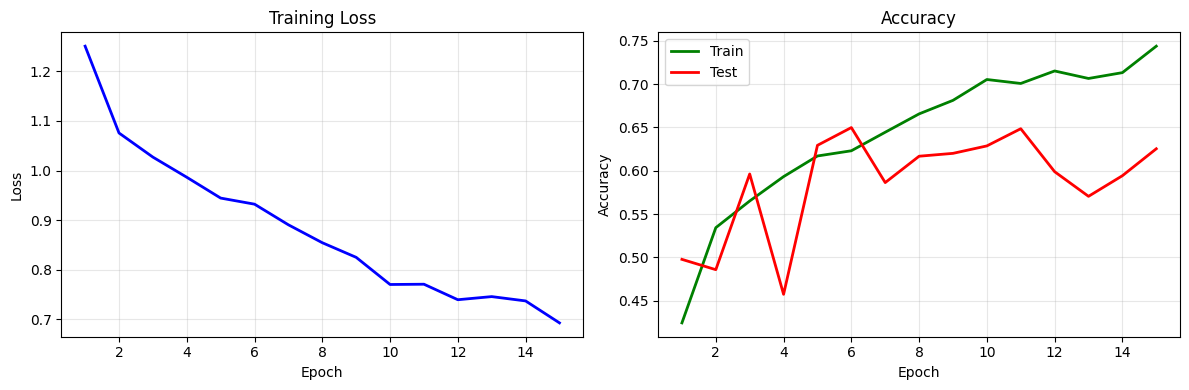

Plot saved!

Complete


In [16]:
# ============================================
# Run
# ============================================

print("Starting ResNet-50 Training\n")

model, history = train_model(
    train_dir=os.path.join(BASE_PATH, 'Training'),
    test_dir=os.path.join(BASE_PATH, 'Testing'),
    epochs=15,
    batch_size=4,
    lr=0.0001
)

print("\nComplete")